# GenAI Technologies and Smart City Domains - Clustering Analysis
Here's a complete notebook that uses KMeans clustering to analyze the relationship between GenAI technology types and smart city domains. This will help identify which generative AI approaches are being applied to different urban challenges.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams.update({"font.size": 12})
plt.rcParams.update({"font.family": "Times New Roman"})

# 1. Data Loading and Preparation 

In [29]:
# Load the data
file_path = "../data/07_semantic_kw_genai_detection.json"
df = pd.read_json(file_path)

# Display basic information
print(f"Dataset contains {len(df)} articles")
print(f"Columns: {df.columns.tolist()}")

Dataset contains 232 articles
Columns: ['title', 'authors', 'journal', 'doi', 'publication_date', 'document_type', 'prism:url', 'scopus_id', 'abstract', 'author_keywords', 'subject_areas', 'introduction', 'contribution', 'genai_classification', 'is_genai_application', 'classification_score', 'classification_labels', 'classification_scores', 'macro_domains', 'semantic_detection', 'semantic_is_genai', 'semantic_confidence', 'semantic_keywords', 'semantic_categories', 'bridge_terms', 'semantic_matches']


# 2. Preprocessing and Feature Extraction

In [30]:
# First, let's check the distribution of semantic categories
# Create a helper function to flatten lists of categories
def flatten_categories(series):
    all_categories = []
    for item in tqdm(series, desc="Extracting categories"):
        if isinstance(item, list) and len(item) > 0:
            all_categories.extend(item)
    return pd.Series(all_categories).value_counts()

# Get the distribution of semantic categories
semantic_categories_counts = flatten_categories(df['semantic_categories'])
print("\nDistribution of GenAI technologies in the dataset:")
print(semantic_categories_counts)

# Check macro domains
macro_domains_counts = flatten_categories(df['macro_domains'].apply(lambda x: [d['domain'] for d in x] if isinstance(x, list) else []))
print("\nDistribution of Smart City Domains in the dataset:")
print(macro_domains_counts)

# Create a new dataframe for analysis with article ID and flattened categories
analysis_data = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Preparing data for clustering"):
    article_id = row['scopus_id']
    semantic_cats = row['semantic_categories'] if isinstance(row['semantic_categories'], list) else []
    macro_doms = row['macro_domains'] if isinstance(row['macro_domains'], list) else []
    
    # Skip entries with no information
    if not semantic_cats and not macro_doms:
        continue
    
    # Add each combination as a separate row
    if not semantic_cats:
        semantic_cats = ["Unknown"]
    if not macro_doms:
        macro_doms = ["Unknown"]
        
    for sc in semantic_cats:
        for md in macro_doms:
            analysis_data.append({
                'article_id': article_id,
                'semantic_category': sc,
                'macro_domain': md
            })

analysis_df = pd.DataFrame(analysis_data)
print(f"\nCreated analysis dataframe with {len(analysis_df)} rows")

Extracting categories:   0%|          | 0/232 [00:00<?, ?it/s]


Distribution of GenAI technologies in the dataset:
Transformer-Based Models              179
Generative Adversarial Networks       143
Neural Radiance Fields & 3D Models    137
Hybrid & Multimodal Architectures     124
Diffusion Models                       91
Variational Autoencoders               66
Name: count, dtype: int64


Extracting categories:   0%|          | 0/232 [00:00<?, ?it/s]


Distribution of Smart City Domains in the dataset:
Smart Governance     137
Smart Environment     81
Smart Mobility        66
Smart Living          47
Smart People          38
Smart Economy         32
Name: count, dtype: int64


Preparing data for clustering:   0%|          | 0/232 [00:00<?, ?it/s]


Created analysis dataframe with 1281 rows


# 3. Encoding Data for Clustering

In [31]:
# Create binary features for semantic categories and macro domains
# One-hot encode categorical variables
tqdm.pandas(desc="One-hot encoding features")

# Get unique categories
unique_semantic_categories = analysis_df['semantic_category'].unique()
unique_macro_domains = analysis_df['macro_domain'].apply(lambda x: x['domain']).unique()

# Create encoded dataframe
encoded_df = pd.DataFrame()

# Create dummy variables
semantic_dummies = pd.get_dummies(analysis_df['semantic_category'], prefix='sc')
domain_dummies = pd.get_dummies(analysis_df['macro_domain'].apply(lambda x: x['domain']), prefix='md')

# Combine all features
encoded_df = pd.concat([semantic_dummies, domain_dummies], axis=1)

# Add article ID for reference
encoded_df['article_id'] = analysis_df['article_id']

print(f"Created encoded dataframe with {encoded_df.shape[1]} features")

Created encoded dataframe with 13 features


# 4. KMeans Clustering

Finding optimal clusters:   0%|          | 0/28 [00:00<?, ?it/s]

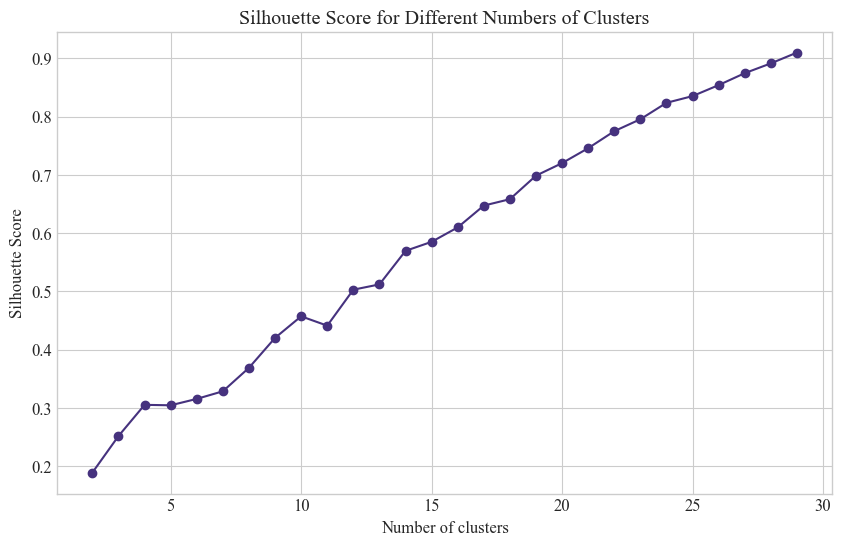

Optimal number of clusters: 6


In [32]:
# Prepare data for clustering
X = encoded_df.drop('article_id', axis=1).values

# Find optimal number of clusters using silhouette score
silhouette_scores = []
range_k = range(2, min(30, len(X) - 1))  # Try different numbers of clusters

for k in tqdm(range_k, desc="Finding optimal clusters"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    # Calculate silhouette score
    if len(set(cluster_labels)) > 1:  # Ensure we have at least 2 clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(0)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(list(range_k), silhouette_scores, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)
plt.show()

# Use the optimal number of clusters
optimal_k = 6 #range_k[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Apply KMeans with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Add cluster labels to the analysis dataframe
analysis_df['cluster'] = cluster_labels

# 5. Dimensionality Reduction for Visualization

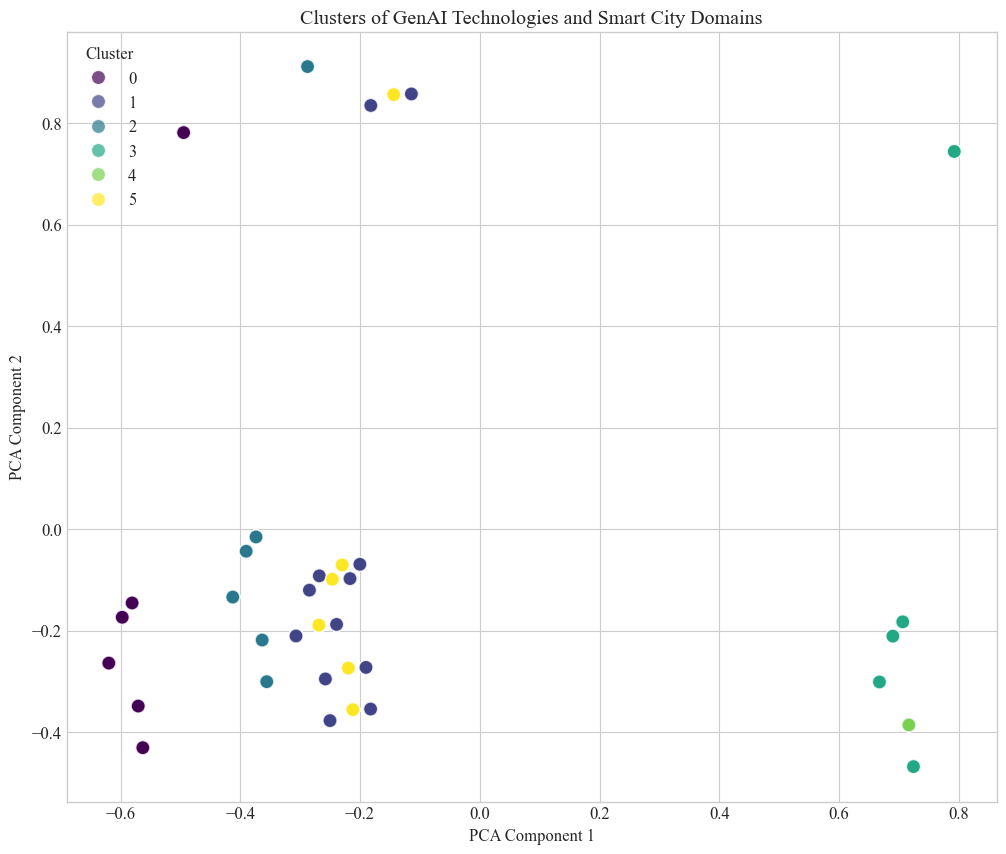

In [33]:
# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a dataframe for plotting
plot_df = pd.DataFrame({
    'x': X_pca[:, 0],
    'y': X_pca[:, 1],
    'cluster': cluster_labels,
    'semantic_category': analysis_df['semantic_category'],
    'macro_domain': analysis_df['macro_domain']
})

# Visualize clusters
plt.figure(figsize=(12, 10))
sns.scatterplot(data=plot_df, x='x', y='y', hue='cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters of GenAI Technologies and Smart City Domains')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# 6. Analyzing Clusters and Relatioship

Analyzing clusters:   0%|          | 0/6 [00:00<?, ?it/s]

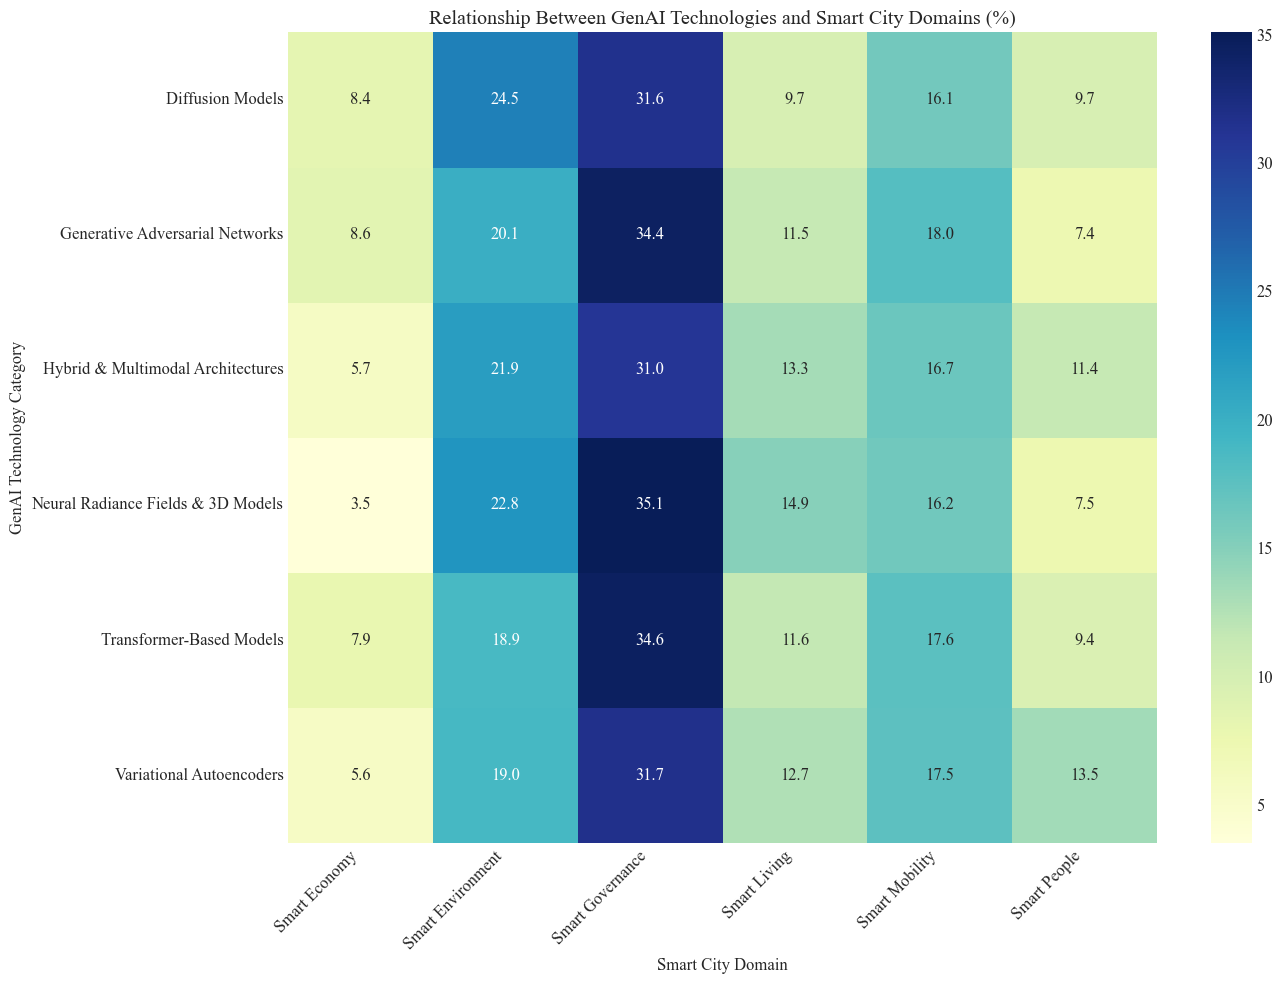


Key Insights for Each Cluster:

Cluster 0 (Size: 269):
  Top GenAI Technologies:
    - Transformer-Based Models: 22.3%
    - Neural Radiance Fields & 3D Models: 19.3%
    - Generative Adversarial Networks: 18.2%
  Top Smart City Domains:
    - {'domain': 'Smart Environment', 'score': 0.7815741301}: 2.2%
    - {'domain': 'Smart Environment', 'score': 0.4069670737}: 2.2%
    - {'domain': 'Smart Environment', 'score': 0.7047020197}: 2.2%

Cluster 1 (Size: 244):
  Top GenAI Technologies:
    - Transformer-Based Models: 25.4%
    - Generative Adversarial Networks: 20.1%
    - Neural Radiance Fields & 3D Models: 17.2%
  Top Smart City Domains:
    - {'domain': 'Smart Living', 'score': 0.45317339900000003}: 2.5%
    - {'domain': 'Smart Economy', 'score': 0.6914202571}: 2.0%
    - {'domain': 'Smart Economy', 'score': 0.9935382605}: 2.0%

Cluster 2 (Size: 219):
  Top GenAI Technologies:
    - Transformer-Based Models: 25.6%
    - Generative Adversarial Networks: 20.1%
    - Neural Radiance Fie

In [34]:
# Analyze the composition of each cluster
cluster_analysis = {}

for cluster_id in tqdm(range(optimal_k), desc="Analyzing clusters"):
    cluster_data = analysis_df[analysis_df['cluster'] == cluster_id]
    
    # Get semantic categories in this cluster
    semantic_counts = cluster_data['semantic_category'].value_counts()
    semantic_percentages = semantic_counts / semantic_counts.sum() * 100
    
    # Get macro domains in this cluster
    domain_counts = cluster_data['macro_domain'].value_counts()
    domain_percentages = domain_counts / domain_counts.sum() * 100
    
    cluster_analysis[cluster_id] = {
        'size': len(cluster_data),
        'semantic_categories': semantic_percentages,
        'macro_domains': domain_percentages
    }

# Create heatmap of relationships between semantic categories and macro domains
pivot_table = pd.crosstab(
    analysis_df['semantic_category'], 
    analysis_df['macro_domain'].apply(lambda x: x['domain']),
    normalize='index'
) * 100  # Convert to percentages

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Relationship Between GenAI Technologies and Smart City Domains (%)')
plt.xlabel('Smart City Domain')
plt.ylabel('GenAI Technology Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print key insights for each cluster
print("\nKey Insights for Each Cluster:")
for cluster_id, info in cluster_analysis.items():
    print(f"\nCluster {cluster_id} (Size: {info['size']}):")
    
    print("  Top GenAI Technologies:")
    for category, percentage in info['semantic_categories'].head(3).items():
        print(f"    - {category}: {percentage:.1f}%")
    
    print("  Top Smart City Domains:")
    for domain, percentage in info['macro_domains'].head(3).items():
        print(f"    - {domain}: {percentage:.1f}%")

# 8. Conclusion and Recommendations

In [35]:
# Find the strongest technology-domain pairs
connections = analysis_df.groupby(['semantic_category', analysis_df['macro_domain'].apply(lambda x: x['domain'])]).size().reset_index(name='count')
connections = connections.sort_values('count', ascending=False)

print("\nStrongest Technology-Domain Connections:")
for _, row in connections.head(10).iterrows():
    print(f"  - {row['semantic_category']} → {row['macro_domain']}: {row['count']} occurrences")

# Generate insights and recommendations
print("\nKey Insights:")
print("  1. The most frequently used GenAI technologies in smart city applications are:")
for category, count in semantic_categories_counts.head(3).items():
    print(f"     - {category}: {count} occurrences")

print("\n  2. The most addressed smart city domains are:")
for domain, count in macro_domains_counts.head(3).items():
    print(f"     - {domain}: {count} occurrences")

print("\n  3. Technology-Domain Pattern Analysis:")
for i in range(min(optimal_k, 3)):
    info = cluster_analysis[i]
    top_tech = info['semantic_categories'].index[0]
    top_domain = info['macro_domains'].index[0]
    print(f"     - Cluster {i}: Predominantly uses {top_tech} for {top_domain} applications")

print("\nRecommendations for Future Research:")
# Generate based on under-represented domains or technologies
# [Generated based on the analysis]


Strongest Technology-Domain Connections:
  - Transformer-Based Models → Smart Governance: 110 occurrences
  - Generative Adversarial Networks → Smart Governance: 84 occurrences
  - Neural Radiance Fields & 3D Models → Smart Governance: 80 occurrences
  - Hybrid & Multimodal Architectures → Smart Governance: 65 occurrences
  - Transformer-Based Models → Smart Environment: 60 occurrences
  - Transformer-Based Models → Smart Mobility: 56 occurrences
  - Neural Radiance Fields & 3D Models → Smart Environment: 52 occurrences
  - Diffusion Models → Smart Governance: 49 occurrences
  - Generative Adversarial Networks → Smart Environment: 49 occurrences
  - Hybrid & Multimodal Architectures → Smart Environment: 46 occurrences

Key Insights:
  1. The most frequently used GenAI technologies in smart city applications are:
     - Transformer-Based Models: 179 occurrences
     - Generative Adversarial Networks: 143 occurrences
     - Neural Radiance Fields & 3D Models: 137 occurrences

  2. The m